In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os
import pandas as pd
import pingouin as pg
import seaborn as sns
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import silhouette_score
import statsmodels.api as sm 
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg
import sys

from IPython.display import HTML
def View(df):
    css = """<style>
    table { border-collapse: collapse; border: 3px solid #eee; }
    table tr th:first-child { background-color: #eeeeee; color: #333; font-weight: bold }
    table thead th { background-color: #eee; color: #000; }
    tr, th, td { border: 1px solid #ccc; border-width: 1px 0 0 1px; border-collapse: collapse;
    padding: 3px; font-family: monospace; font-size: 10px }</style>
    """
    s  = '<script type="text/Javascript">'
    s += 'var win = window.open("", "Title", "toolbar=no, location=no, directories=no, status=no, menubar=no, scrollbars=yes, resizable=yes, width=780, height=200, top="+(screen.height-400)+", left="+(screen.width-840));'
    s += 'win.document.body.innerHTML = \'' + (df.to_html() + css).replace("\n",'\\') + '\';'
    s += '</script>'
    return(HTML(s+css))    
    
print("Current Working directory " , os.getcwd())

Current Working directory  C:\Users\User\GitHub\WebET_Analysis


In [2]:
# from IPython.display import HTML

# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Read data

In [3]:
data_et = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_et.csv')
data_trial = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_trial.csv')
data_subject = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_subject.csv')

overview = pd.DataFrame(
    [
        [len(data_et)],
        [len(data_trial)],
        [len(data_subject)]
    ], 
    columns=['length'],
    index=[
        'data_et', 
        'data_trial', 
        'data_subject'
          ]
)
print(overview)

              length
data_et       618566
data_trial     30362
data_subject      84


# Create datasets

## Position index

In [4]:
def addPositionIndex(data):
    data['positionIndex'] = 0

    x_pos = [0.2, 0.5, 0.8, 0.2, 0.5, 0.8, 0.2, 0.5, 0.8, 0.35, 0.65, 0.35, 0.65]
    y_pos = [0.2, 0.2, 0.2, 0.5, 0.5, 0.5, 0.8, 0.8, 0.8, 0.35, 0.35, 0.65, 0.65]

    for i in range(0, len(x_pos)):
        data.loc[(data['x_pos']==x_pos[i]) & (data['y_pos']==y_pos[i]), 'positionIndex']=i
    return data

data_trial = addPositionIndex(data_trial)

data_trial.loc[
    (data_trial['trial_type']=='eyetracking-calibration'), ['x_pos', 'y_pos', 'positionIndex']] \
    .drop_duplicates() \
    .sort_values(by='positionIndex')

,x_pos,y_pos,positionIndex
41,0.20,0.20,0
27,0.50,0.20,1
17,0.80,0.20,2
21,0.20,0.50,3
37,0.50,0.50,4
33,0.80,0.50,5
39,0.20,0.80,6
31,0.50,0.80,7
29,0.80,0.80,8
25,0.35,0.35,9


## data_et

In [5]:
def add_var_to_data_et(data_et, source_data, varName):
    if varName in data_et.columns: data_et=data_et.drop(columns=varName)
    data_et = data_et.merge(
        source_data.loc[:, ['run_id', 'trial_index', varName]], 
        on=['run_id', 'trial_index'], how='left')
    return data_et

data_et = add_var_to_data_et(data_et, data_trial, 'task_nr')
data_et = add_var_to_data_et(data_et, data_trial, 'chin')
data_et = add_var_to_data_et(data_et, data_trial, 'chinFirst')
data_et = add_var_to_data_et(data_et, data_trial, 'trial_type')
data_et = add_var_to_data_et(data_et, data_trial, 'trial_duration')
data_et = add_var_to_data_et(data_et, data_trial, 'trial_duration_exact')
data_et = add_var_to_data_et(data_et, data_trial, 'x_pos')
data_et = add_var_to_data_et(data_et, data_trial, 'y_pos')
data_et = add_var_to_data_et(data_et, data_trial, 'window_width')
data_et = add_var_to_data_et(data_et, data_trial, 'window_height')

## data_trial

In [6]:
if 'glasses_binary' in data_trial.columns:
    data_trial = data_trial.drop(columns=['glasses_binary'])
data_trial = data_trial.merge(
    data_subject.loc[:, ['run_id', 'glasses_binary']],
    on='run_id',
    how='left'
)

## data_et_fix

In [7]:
data_et_fix = data_et.loc[
    (data_et['trial_type']=='eyetracking-fix-object') &
    (data_et['trial_duration']==5000) &
    (data_et['t_task']>1000),     :
]

## data_trial_fix

In [8]:
data_trial_fix = data_trial.loc[
    (data_trial['trial_type']=='eyetracking-fix-object') &
    (data_trial['trial_duration']==5000),     :
].drop(columns=[
    'trial_type', 'trial_duration', 
    'choiceTask_amountLeftFirst',
    'option_topLeft', 'option_bottomLeft',
    'option_topRight', 'option_bottomRight',
    'chosenAmount', 'chosenDelay']
      )

# Screening

## Not enough trials

In [9]:
NTrials = data_trial.groupby(['run_id'])['trial_index'].max() \
    .reset_index()
subjects_notEnoughTrials = NTrials.loc[NTrials['trial_index']<400, 'run_id']
print('These subjects do not have enough trials: \n' + 
      str(NTrials.loc[NTrials['trial_index']<400, :])
     )

These subjects do not have enough trials: 
    run_id  trial_index
27      61        271.0
46     125         15.0
56    2002        112.0
59    2011         32.0


In [10]:
temp = data_trial_fix.groupby(['run_id'])['trial_index'].max() \
    .reset_index()
subjects_notEnoughTrials_fix = temp.loc[temp['trial_index']<131, 'run_id']
temp.loc[temp['trial_index']<131, :]

,run_id,trial_index
27,61,130.0
31,70,130.0


In [11]:
subjects_notEnoughTrials = list(
    set(subjects_notEnoughTrials) | 
    set(subjects_notEnoughTrials_fix)
)
subjects_notEnoughTrials

[2002, 61, 70, 2011, 125]

## Not following intructions 

In [12]:
data_subject.loc[
    (data_subject['keptHead']==0) |
    (data_subject['triedChin']==0), 
    ['run_id', 'prolificID', 'keptHead', 'triedChin']
]

,run_id,prolificID,keptHead,triedChin
5,12,5b8969006651ea000118e42e,1.0,0.0
29,48,5fa1192cf99e161a5cfad1cd,1.0,0.0
51,9,5fea6632bf9ae4a79153efdf,1.0,0.0
72,1003,0,1.0,0.0
74,1008,Ka61Kl61,1.0,0.0
81,2002,Tim2,0.0,0.0
82,2008,Studie1970,0.0,1.0


In [13]:
subjects_noInstruction = data_subject.loc[
    (data_subject['keptHead']==0) |
    (data_subject['triedChin']==0), 
    'run_id'
].reset_index(drop=True)

## High t_task

In [14]:
data_et_fix.loc[data_et_fix['t_task']>5500, :] \
    .groupby(['run_id'])['x'].count()

run_id
1.0       27
9.0       37
70.0      18
80.0      18
97.0      29
1021.0     2
2008.0     1
2012.0    28
Name: x, dtype: int64

In [15]:
data_trial_fix.loc[data_trial_fix['trial_duration_exact']>5500, :] \
    .groupby(['run_id', 'trial_index']).mean() \
    .reset_index() \
    .loc[:, ['run_id', 'trial_index', 'trial_duration_exact']]

,run_id,trial_index,trial_duration_exact
0,1,106.0,6337.0
1,1,109.0,6371.0
2,1,112.0,6296.0
3,1,115.0,6318.0
4,1,118.0,6310.0
...,...,...,...
101,2012,243.0,7092.0
102,2012,246.0,7230.0
103,2012,249.0,7122.0
104,2012,252.0,6075.0


## Not approved by prolific

In [16]:
data_subject.loc[
    ~data_subject['status'].isin(['APPROVED', 'NOTPROLIFIC']),
    :
]

,run_id,birthyear,browliner,browser,browser_version,degree,device,ethnic,eyeliner,eyeshadow,...,precision,precision_chin_0,precision_chin_1,precision_glasses_binary_0,precision_glasses_binary_1,precision_px,precision_px_chin_0,precision_px_chin_1,precision_px_glasses_binary_0,precision_px_glasses_binary_1
7,125,NaN,NaN,Chrome,87.0.4280.88,NaN,Macintosh,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
subjects_notApproved = data_subject.loc[
    ~data_subject['status'].isin(['APPROVED', 'NOTPROLIFIC']),
    'run_id'
]
subjects_notApproved

7    125
Name: run_id, dtype: int64

# Cleaning

In [18]:
excludedSubjects = list(
    set(subjects_notEnoughTrials) | 
    set(subjects_noInstruction) |
    set(subjects_notApproved)
)
excludedSubjects

[70, 9, 1003, 12, 48, 1008, 2002, 61, 2008, 2011, 125]

## data_subject variables

In [19]:
data_subject['degree'] = data_subject['degree'].replace({'0': np.nan, '-3.0': np.nan})
data_subject['webcam_fps'] = np.round(data_subject['webcam_fps'])

In [20]:
data_subject = data_subject.loc[~data_subject['run_id'].isin(excludedSubjects), :]
print(data_subject['run_id'].unique())

[   1  103  106  108   11  124  126  128   13  130  131   14   19   24
   25   28   30   32   36   37   38    4   41   42   43   45   47   49
    5   54   56   58   59    6   63   66   67    7   72   74   75   80
   81   83   85   88   90   91   92   93   94   96   97   98   99 1000
 1001 1011 1014 1015 1016 1017 1019 1002 1020 1021 1007 1009 1022 1024
 2012 2013 2009]


## Trial data

In [21]:
def cleanTrialData(data):
    print('raw data: ' + str(len(data)))
    data = data \
        .loc[~data['run_id'].isin(excludedSubjects), :] \
        .reset_index(drop=True)
    print('cleaned data: ' + str(len(data)))
    return data

print('data_trial')
data_trial = cleanTrialData(data_trial)
print('\n data_trial_fix')
data_trial_fix = cleanTrialData(data_trial_fix)
data_trial_fix = data_trial_fix.loc[
    data_trial_fix['trial_duration_exact']<5500, 
    :
]

data_trial
raw data: 30362
cleaned data: 26422

 data_trial_fix
raw data: 1044
cleaned data: 918


## Eyetracking data
Exclude subjects, and trials with high duration

In [22]:
def cleanETData(data):
    print('raw data: ' + str(len(data)))
    data = data \
        .loc[~data['run_id'].isin(excludedSubjects), :] \
        .reset_index(drop=True)
    print('cleaned data: ' + str(len(data)))
    return data

print('data_et')
data_et = cleanETData(data_et)

print('\n data_et_fix')
data_et_fix = cleanETData(data_et_fix)
data_et_fix = data_et_fix.loc[
    data_et_fix['trial_duration_exact']<5500,
    :
]

data_et
raw data: 618566
cleaned data: 543740

 data_et_fix
raw data: 65042
cleaned data: 58113


# Offset

## Calculate on gaze point-level

In [23]:
data_trial.loc[
    data_trial['trial_type'].isin(['eyetracking-fix-object']), 
    ['trial_index', 'window_width']]

,trial_index,window_width
104,105.0,1920.0
105,106.0,1920.0
107,108.0,1920.0
108,109.0,1920.0
110,111.0,1920.0
...,...,...
26147,243.0,1920.0
26150,246.0,1920.0
26153,249.0,1920.0
26156,252.0,1920.0


In [24]:
def euclideanDistance(x, x_target, y, y_target):
    x_diff = x - x_target
    y_diff = y - y_target
    euclideanDistance = np.sqrt(x_diff**2 + y_diff**2)
    return(euclideanDistance)

data_et.loc[:, "offset"] = euclideanDistance(
        data_et["x"], data_et['x_pos'],
        data_et["y"], data_et['y_pos'])
data_et_fix.loc[:, "offset"] = euclideanDistance(
        data_et_fix["x"], data_et_fix['x_pos'],
        data_et_fix["y"], data_et_fix['y_pos'])

Offset as pixels

In [25]:
data_et.loc[:, "offset_px"] = euclideanDistance(
    (data_et["x"] * data_et['window_width']), 
    (data_et['x_pos'] * data_et['window_width']),
    (data_et["y"] * data_et['window_height']), 
    (data_et['y_pos'] * data_et['window_height'])
)
data_et_fix.loc[:, "offset_px"] = euclideanDistance(
    (data_et_fix["x"] * data_et_fix['window_width']), 
    (data_et_fix['x_pos'] * data_et_fix['window_width']),
    (data_et_fix["y"] * data_et_fix['window_height']), 
    (data_et_fix['y_pos'] * data_et_fix['window_height'])
)
data_et_fix['offset_px'].describe()

count    57392.000000
mean       206.439607
std        187.554771
min          0.908491
25%         88.649353
50%        151.594798
75%        263.036349
max       2313.307199
Name: offset_px, dtype: float64

## Plot: gaze shift within a trial

In [26]:
def select_fixTask_and_fixCross(data):
    return data.loc[
        (data['trial_type']=='eyetracking-fix-object') & 
        ((data['task_nr']==1) |
            ((data['chinFirst']==0) & (data['task_nr']==2)) |
            ((data['chinFirst']==1) & (data['task_nr']==3))
        ), :]. reset_index(drop=True)

def reformatTTask(data):                                                 
    data.loc[
        (data['trial_type']=='eyetracking-fix-object') & 
        (data['trial_duration']==1500), 
        't_task'
    ] = data.loc[
        (data['trial_type']=='eyetracking-fix-object') &
        (data['trial_duration']==1500), 
        't_task'
    ] - 1500
    return data


data_et_fix_task_fixCross = reformatTTask(select_fixTask_and_fixCross(data_et))

def add_next_xy_pos(data):
    data['next_x_pos']=0
    data['next_y_pos']=0
    for i in data.index:
        if data.loc[i, 'trial_duration']==1500:
            data.loc[i, 'next_x_pos'] = data.loc[i+1, 'x_pos']
            data.loc[i, 'next_y_pos'] = data.loc[i+1, 'y_pos']
    return(data)

data_trial_fix_task_fixCross = add_next_xy_pos(select_fixTask_and_fixCross(data_trial))

data_et_fix_task_fixCross = data_et_fix_task_fixCross.merge(
    data_trial_fix_task_fixCross.loc[:, ['run_id', 'trial_index', 'next_x_pos', 'next_y_pos']],
    on=['run_id', 'trial_index'],
    how='left'
)

In [27]:
def new_distance_for_fixCross(data):
    data.loc[data['trial_duration']==1500, 'offset'] = euclideanDistance(
        data.loc[data['trial_duration']==1500, 'x'], 
        data.loc[data['trial_duration']==1500, 'next_x_pos'], 
        data.loc[data['trial_duration']==1500, 'y'], 
        data.loc[data['trial_duration']==1500, 'next_y_pos']
    )
    return data
        
data_et_fix_task_fixCross = new_distance_for_fixCross(data_et_fix_task_fixCross)

In [28]:
def createAVGLine(data):
    binArray = np.arange(-1500, 5000, 50)
    bins = pd.cut(data['t_task'], binArray)
    output = data.groupby(bins).agg({"offset": "median"}).reset_index()
    output['t_task'] = binArray[0:len(output)]
    return output

average_line_noChin = createAVGLine(data_et_fix_task_fixCross.loc[data_et_fix_task_fixCross['chin']==0, :])
average_line_chin = createAVGLine(data_et_fix_task_fixCross.loc[data_et_fix_task_fixCross['chin']==1, :])

Text(0.5, 0, 't_task')

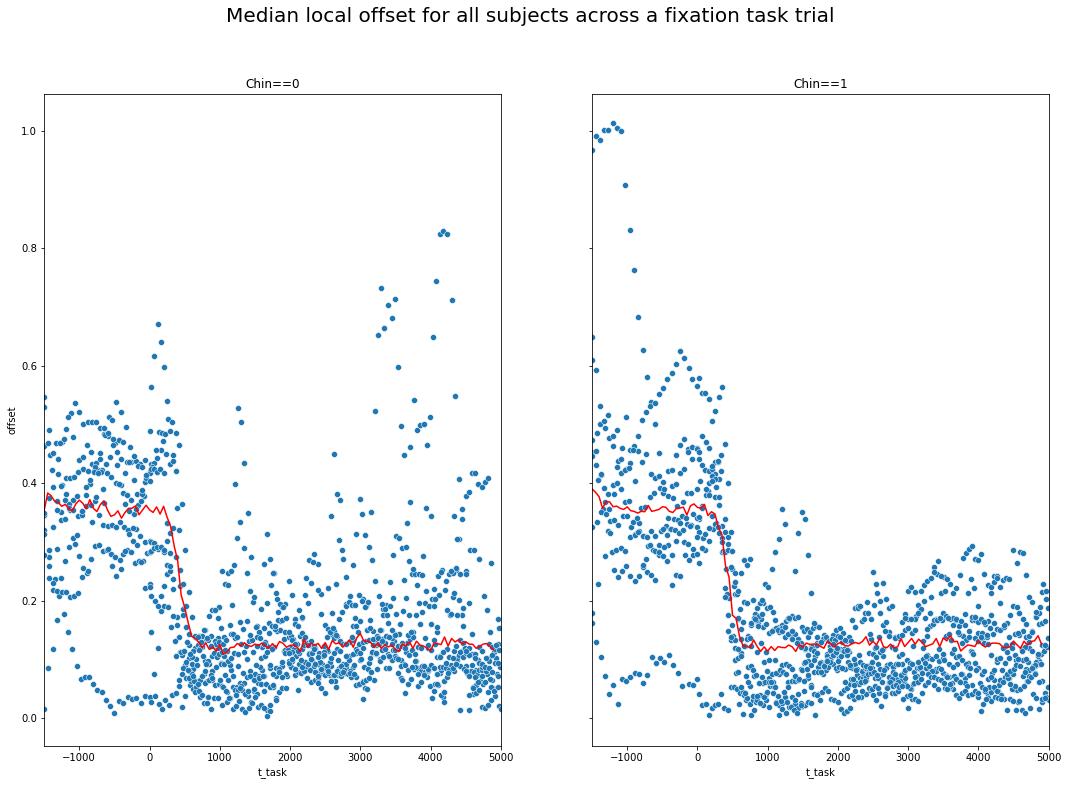

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(18, 12))
fig.suptitle('Median local offset for all subjects across a fixation task trial', fontsize=20)

axes[0].set_title("Chin==0")
axes[1].set_title("Chin==1")

sns.scatterplot(ax=axes[0], 
                data=data_et_fix_task_fixCross.loc[
                    (data_et_fix_task_fixCross['run_id']==103) & 
                    (data_et_fix_task_fixCross['chin']==0), 
                    :], 
                x="t_task", y="offset")
sns.lineplot(ax=axes[0], x=average_line_noChin['t_task'], y=average_line_noChin['offset'], color='r')

sns.scatterplot(ax=axes[1], 
                data=data_et_fix_task_fixCross.loc[
                    (data_et_fix_task_fixCross['run_id']==103) & 
                    (data_et_fix_task_fixCross['chin']==1), 
                    :],
                x="t_task", y="offset")
sns.lineplot(ax=axes[1], x=average_line_chin['t_task'], y=average_line_chin['offset'], color='r')

plt.setp(axes, xlim=(-1500, 5000)) 
plt.xlabel("t_task")

## Aggregate on trial level

In [30]:
def merge_varMean_by_index(data, data_et, varName):
    if varName in data.columns: 
        data = data.drop(columns=[varName])
    grouped = data_et.groupby(['run_id', 'trial_index'])[varName].mean() \
        .reset_index()        
    data = data.merge(grouped, on=['run_id', 'trial_index'], how='left')
    return data

data_trial = merge_varMean_by_index(data_trial, data_et, 'offset')
data_trial_fix = merge_varMean_by_index(data_trial_fix, data_et_fix, 'offset')
data_trial = merge_varMean_by_index(data_trial, data_et, 'offset_px')
data_trial_fix = merge_varMean_by_index(data_trial_fix, data_et_fix, 'offset_px')

## Aggregate on subject-level 

In [31]:
def merge_by_subject(data, large_data, varName):
    if varName in data.columns: data = data.drop(columns=[varName])
    grouped = large_data.groupby(['run_id'])[varName].mean() \
        .reset_index()        
    data = data.merge(grouped, on=['run_id'], how='left')
    return data

data_subject = merge_by_subject(data_subject, data_trial_fix, 'offset')
data_subject = merge_by_subject(data_subject, data_trial_fix, 'offset_px')

In [32]:
def separate_outcomes_by_condition(data, large_data, varName, varCondition):
    var_cond_0 = varName + '_' + varCondition + '_0' 
    var_cond_1 = varName + '_' + varCondition + '_1' 
    
    if var_cond_0 in data.columns: 
        data = data.drop(columns=[var_cond_0])
    if var_cond_1 in data.columns: 
        data = data.drop(columns=[var_cond_1])
        
    grouped = large_data \
        .groupby(['run_id', varCondition])[varName].mean() \
        .reset_index() \
        .pivot(index='run_id', columns=varCondition, values=varName) \
        .reset_index() \
        .rename(columns={0.0: var_cond_0, 1.0: var_cond_1}) 
    data = data.merge(grouped.loc[:, ['run_id', var_cond_0, var_cond_1]], on='run_id', how='left')
    return data

data_subject = separate_outcomes_by_condition(
    data_subject, data_trial_fix, 'offset', 'chin')

data_subject = separate_outcomes_by_condition(
    data_subject, data_trial_fix, 'offset', 'glasses_binary')
data_subject.loc[
    :, 
    [
        'offset', 'offset_chin_0', 'offset_chin_1',
        'offset_glasses_binary_0', 'offset_glasses_binary_1'
    ]
].describe()

,offset,offset_chin_0,offset_chin_1,offset_glasses_binary_0,offset_glasses_binary_1
count,42.000000,42.000000,42.000000,26.000000,15.000000
mean,0.189287,0.187336,0.190088,0.186347,0.198186
std,0.137479,0.146220,0.137603,0.158221,0.101560
min,0.074473,0.069502,0.058736,0.077386,0.074473
25%,0.105193,0.091033,0.103886,0.105466,0.100085
50%,0.145358,0.145691,0.145555,0.143643,0.194038
75%,0.214305,0.223869,0.249133,0.203550,0.261406
max,0.803767,0.802738,0.804795,0.803767,0.410388


In [33]:
data_subject = separate_outcomes_by_condition(data_subject, data_trial_fix, 'offset_px', 'chin')
data_subject = separate_outcomes_by_condition(data_subject, data_trial_fix, 'offset_px', 'glasses_binary')

data_subject.loc[
    :, 
    [
        'offset_px', 'offset_px_chin_0', 'offset_px_chin_1',
        'offset_px_glasses_binary_0', 'offset_px_glasses_binary_1'
    ]
].describe()

,offset_px,offset_px_chin_0,offset_px_chin_1,offset_px_glasses_binary_0,offset_px_glasses_binary_1
count,42.000000,42.000000,42.000000,26.000000,15.000000
mean,223.296746,222.696675,222.633321,215.395420,243.730015
std,158.617168,174.027103,158.607643,169.646149,144.899037
min,83.776446,60.291561,67.162307,83.776446,84.165071
25%,120.951179,112.699178,123.591381,114.505042,140.725287
50%,174.150998,170.132077,182.185218,167.087227,232.007817
75%,263.363737,261.879914,249.786303,244.716665,295.796382
max,847.848319,848.289765,847.406873,847.848319,632.730659


## Grand mean offset

In [34]:
grouped = data_et_fix.groupby(['run_id', 'trial_index']) \
    ['x', 'y'].mean() \
    .reset_index() \
    .rename(columns={'x': 'x_mean', 'y': 'y_mean'})

if 'x_mean' in data_trial_fix.columns:
    data_trial_fix = data_trial_fix.drop(columns=['x_mean'])
if 'y_mean' in data_trial_fix.columns:
    data_trial_fix = data_trial_fix.drop(columns=['y_mean'])    
data_trial_fix = data_trial_fix.merge(
    grouped,
    on=['run_id', 'trial_index'],
    how='left'
) 
data_trial_fix['x_mean_px'] = data_trial_fix['x_mean'] * data_trial_fix['window_width']
data_trial_fix['y_mean_px'] = data_trial_fix['y_mean'] * data_trial_fix['window_height']
data_trial_fix.loc[:, ['x_mean', 'x_mean_px', 'y_mean', 'y_mean_px']].describe()

<ipython-input-34-066a389a9d25>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped = data_et_fix.groupby(['run_id', 'trial_index']) \


,x_mean,x_mean_px,y_mean,y_mean_px
count,753.000000,753.000000,753.000000,753.000000
mean,0.501225,797.284794,0.491179,443.637457
std,0.236219,413.692311,0.211837,212.288555
min,-0.128611,-175.682599,-0.119299,-128.842889
25%,0.296808,486.736862,0.337961,291.995835
50%,0.510968,770.957844,0.504386,429.843527
75%,0.721858,1058.430820,0.652206,578.608672
max,1.032567,2282.275511,0.993750,1126.277549


In [35]:
data_trial_fix['grand_deviation'] = euclideanDistance(
    data_trial_fix['x_mean'], data_trial_fix['x_pos'],
    data_trial_fix['y_mean'], data_trial_fix['y_pos']
)
data_trial_fix['grand_deviation'].describe()

count    753.000000
mean       0.170966
std        0.168947
min        0.003546
25%        0.067490
50%        0.120945
75%        0.214023
max        1.285896
Name: grand_deviation, dtype: float64

# Precision

## Distance from AVG on et-level

In [36]:
def merge_xy_means(data):    
    grouped = data.groupby(['run_id', 'trial_index'])['x', 'y'].mean() \
        .rename(columns={'x': 'x_mean', 'y': 'y_mean'})
    
    if 'x_mean' in data.columns: 
        data = data.drop(columns=['x_mean'])
    if 'y_mean' in data.columns: 
        data = data.drop(columns=['y_mean'])
    data = data.merge(grouped, on=['run_id', 'trial_index'], how='left') 
    return(data)

def distanceFromAVG_square(data):
    data = merge_xy_means(data)
    data['distanceFromAVG_square'] = np.power(
        euclideanDistance(data['x'], data['x_mean'], data['y'], data['y_mean']),
        2
    )
    data['distanceFromAVG_square_px'] = np.power(euclideanDistance(
        (data['x'] * data_et['window_width']), 
        (data['x_mean'] * data_et['window_width']), 
        (data['y'] * data_et['window_height']), 
        (data['y_mean'] * data_et['window_height'])
    ), 2)
    
    return(data)  

data_et = distanceFromAVG_square(data_et)
data_et_fix = distanceFromAVG_square(data_et_fix)
print(data_et_fix.loc[
    pd.isna(data_et_fix['distanceFromAVG_square']), 
    ['x', 'y', 'x_pos', 'y_pos', 'distanceFromAVG_square']
])
data_et_fix.loc[
    :, ['distanceFromAVG_square', 'distanceFromAVG_square_px']] \
    .describe()

<ipython-input-36-ca53af98e2a3>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped = data.groupby(['run_id', 'trial_index'])['x', 'y'].mean() \


Empty DataFrame
Columns: [x, y, x_pos, y_pos, distanceFromAVG_square]
Index: []


,distanceFromAVG_square,distanceFromAVG_square_px
count,5.739200e+04,5.739200e+04
mean,9.282018e-03,1.059287e+04
std,3.119656e-02,3.712064e+04
min,8.822143e-10,7.388290e-04
25%,9.337675e-04,1.027229e+03
50%,2.761676e-03,3.103470e+03
75%,7.311242e-03,8.340324e+03
max,1.279031e+00,2.024417e+06


## Standard deviation of gaze points on trial-level

In [37]:
data_trial = merge_varMean_by_index(
    data_trial, data_et, 'distanceFromAVG_square')
data_trial['precision'] = np.sqrt(data_trial['distanceFromAVG_square'])

data_trial_fix = merge_varMean_by_index(
    data_trial_fix, data_et_fix, 'distanceFromAVG_square')
data_trial_fix['precision'] = np.sqrt(data_trial_fix['distanceFromAVG_square'])
print(data_trial_fix['precision'].describe())

count    753.000000
mean       0.082346
std        0.060537
min        0.000341
25%        0.050865
50%        0.067183
75%        0.092336
max        0.599281
Name: precision, dtype: float64


In pixel

In [38]:
data_trial = merge_varMean_by_index(
    data_trial, data_et, 'distanceFromAVG_square_px')
data_trial['precision_px'] = np.sqrt(data_trial['distanceFromAVG_square_px'])

data_trial_fix = merge_varMean_by_index(
    data_trial_fix, data_et_fix, 'distanceFromAVG_square_px')
data_trial_fix['precision_px'] = np.sqrt(data_trial_fix['distanceFromAVG_square_px'])
print(data_trial_fix['precision_px'].describe())

count    753.000000
mean      88.372342
std       66.269935
min        0.338321
25%       54.651894
50%       70.806793
75%       98.402934
max      678.197552
Name: precision_px, dtype: float64


Any missing values?

In [39]:
data_trial_fix.loc[
    pd.isna(data_trial_fix['precision']), 
    ['run_id', 'trial_index', 'x_pos', 'y_pos', 'precision']
]

,run_id,trial_index,x_pos,y_pos,precision
270,38,106.0,0.2,0.8,NaN
271,38,109.0,0.5,0.5,NaN
272,38,112.0,0.8,0.5,NaN
273,38,115.0,0.2,0.5,NaN
274,38,118.0,0.5,0.2,NaN
...,...,...,...,...,...
749,98,243.0,0.8,0.2,NaN
750,98,246.0,0.2,0.8,NaN
751,98,249.0,0.2,0.5,NaN
752,98,252.0,0.5,0.5,NaN


## Aggregate on subject-level 

In [40]:
data_subject = merge_by_subject(data_subject, data_trial_fix, 'precision')
data_subject = separate_outcomes_by_condition(
    data_subject, data_trial_fix, 'precision', 'chin')
data_subject = separate_outcomes_by_condition(
    data_subject, data_trial_fix, 'precision', 'glasses_binary')
data_subject.loc[
    :, 
    [
        'precision', 'precision_chin_0', 'precision_chin_1',
        'precision_glasses_binary_0', 'precision_glasses_binary_1'
    ]
].describe()

,precision,precision_chin_0,precision_chin_1,precision_glasses_binary_0,precision_glasses_binary_1
count,42.000000,42.000000,42.000000,26.000000,15.000000
mean,0.083325,0.086388,0.079449,0.080702,0.088290
std,0.051085,0.056255,0.049525,0.053549,0.049799
min,0.003469,0.004836,0.002101,0.045034,0.003469
25%,0.058795,0.063243,0.054928,0.055661,0.067032
50%,0.073681,0.075681,0.067942,0.067442,0.077988
75%,0.089642,0.088269,0.086965,0.087535,0.093848
max,0.329039,0.397298,0.255742,0.329039,0.215294


In pixel

In [41]:
data_subject = merge_by_subject(data_subject, data_trial_fix, 'precision_px')
data_subject = separate_outcomes_by_condition(
    data_subject, data_trial_fix, 'precision_px', 'chin')
data_subject = separate_outcomes_by_condition(
    data_subject, data_trial_fix, 'precision_px', 'glasses_binary')
data_subject.loc[
    :, 
    [
        'precision_px', 'precision_px_chin_0', 'precision_px_chin_1',
        'precision_px_glasses_binary_0', 'precision_px_glasses_binary_1'
    ]
].describe()

,precision_px,precision_px_chin_0,precision_px_chin_1,precision_px_glasses_binary_0,precision_px_glasses_binary_1
count,42.000000,42.000000,42.000000,26.000000,15.000000
mean,89.443234,93.392977,84.442323,88.861113,90.162297
std,56.020796,65.338175,49.063812,60.505659,51.486934
min,3.218977,4.088138,2.349815,48.540134,3.218977
25%,63.070824,67.065680,57.428629,60.279345,68.187389
50%,76.762828,76.241795,74.222176,74.551526,83.213376
75%,92.888817,96.578404,96.520536,91.741411,90.935507
max,358.237167,446.535285,252.198697,358.237167,204.153740


# Main effect: chin-rest

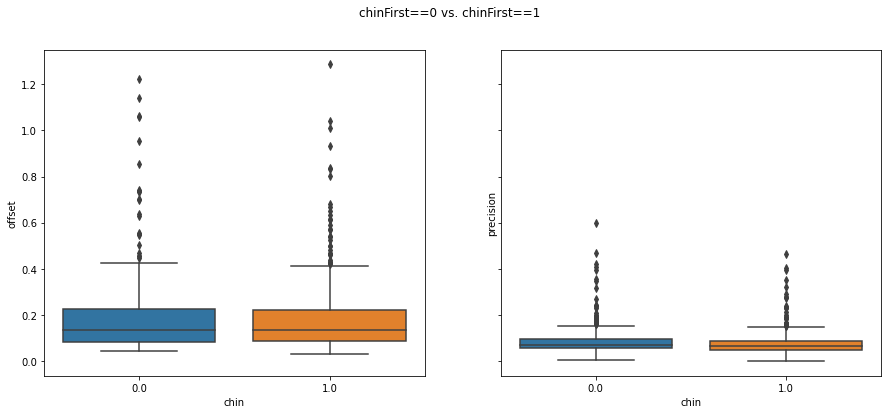

In [42]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('chinFirst==0 vs. chinFirst==1')

sns.boxplot(ax=axes[0], x='chin', y='offset', data=data_trial_fix)
sns.boxplot(ax=axes[1], x='chin', y='precision', data=data_trial_fix)
   
plt.show()

In [43]:
means_0 = data_subject.loc[:, ['offset_chin_0', 'offset_chin_1', 'precision_chin_0', 'precision_chin_1']].mean() \
    .reset_index() \
    .rename(columns={0: 'mean'})
var_0 = data_subject.loc[:, ['offset_chin_0', 'offset_chin_1', 'precision_chin_0', 'precision_chin_1']].var() \
    .reset_index() \
    .rename(columns={0: 'var'})
means_0.merge(var_0, on='index', how='left')

,index,mean,var
0,offset_chin_0,0.187336,0.021380
1,offset_chin_1,0.190088,0.018935
2,precision_chin_0,0.086388,0.003165
3,precision_chin_1,0.079449,0.002453


In [44]:
test_data = data_subject.loc[
    pd.notna(data_subject['offset_chin_0']) & 
    pd.notna(data_subject['offset_chin_1']), :]
scipy.stats.ttest_rel(test_data['offset_chin_0'], test_data['offset_chin_1'])

Ttest_relResult(statistic=-0.21884454358289437, pvalue=0.8278569152750408)

## Compare across chinFirst condition

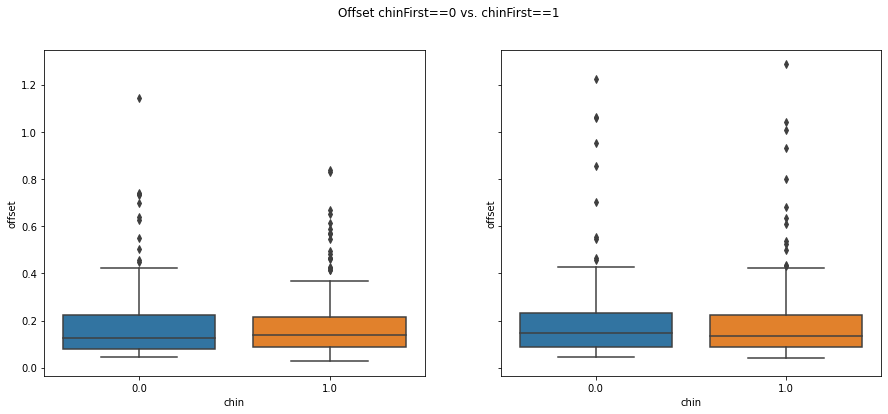

In [45]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('Offset chinFirst==0 vs. chinFirst==1')

sns.boxplot(ax=axes[0], x='chin', y='offset', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==0, :])
sns.boxplot(ax=axes[1], x='chin', y='offset', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==1, :])
   
plt.show()

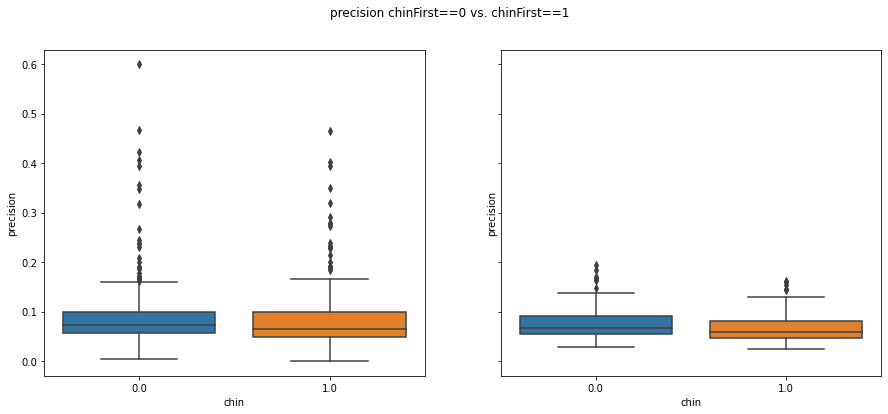

In [46]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('precision chinFirst==0 vs. chinFirst==1')

sns.boxplot(ax=axes[0], x='chin', y='precision', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==0, :])
sns.boxplot(ax=axes[1], x='chin', y='precision', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==1, :])
   
plt.show()

## Compare across fixation dot positions

In [47]:
grouped_var = data_trial_fix.groupby(['positionIndex', 'chin']) \
    ['offset', 'precision'].var() \
    .rename(columns={'offset': 'offset_var', 'precision':'precision_var'}) \
    .reset_index()

grouped_means = data_trial_fix.groupby(['positionIndex', 'chin']) \
    ['offset', 'precision'].mean() \
    .reset_index()

grouped = grouped_means.merge(grouped_var, on=['positionIndex', 'chin'], how='left')

grouped_offset = grouped.loc[:, ['positionIndex', 'chin', 'offset']] \
    .set_index(['positionIndex']) \
    .pivot(columns="chin")['offset'] \
    .reset_index() \
    .rename(columns={0.0: 'offset_chin_0', 1.0: 'offset_chin_1'}) 

grouped_offset_var = grouped.loc[:, ['positionIndex', 'chin', 'offset_var']] \
    .set_index(['positionIndex']) \
    .pivot(columns="chin")['offset_var'] \
    .reset_index() \
    .rename(columns={0.0: 'offset_var_chin_0', 1.0: 'offset_var_chin_1'}) 

grouped_precision = grouped.loc[:, ['positionIndex', 'chin', 'precision']] \
    .set_index(['positionIndex']) \
    .pivot(columns="chin")['precision'] \
    .reset_index() \
    .rename(columns={0.0: 'precision_chin_0', 1.0: 'precision_chin_1'}) 

grouped_precision_var = grouped.loc[:, ['positionIndex', 'chin', 'precision_var']] \
    .set_index(['positionIndex']) \
    .pivot(columns="chin")['precision_var'] \
    .reset_index() \
    .rename(columns={0.0: 'precision_var_chin_0', 1.0: 'precision_var_chin_1'}) 

overview = pd.concat(
    [
        grouped_offset,
        grouped_offset_var.iloc[:, 1:3],
        grouped_precision.iloc[:, 1:3], 
        grouped_precision_var.iloc[:, 1:3]
    ], 
    axis=1
)

print(overview.mean(numeric_only=True))
overview

chin
positionIndex           4.000000
offset_chin_0           0.187336
offset_chin_1           0.188276
offset_var_chin_0       0.027940
offset_var_chin_1       0.027375
precision_chin_0        0.086388
precision_chin_1        0.078244
precision_var_chin_0    0.004044
precision_var_chin_1    0.003308
dtype: float64


<ipython-input-47-15d38b239ff3>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_var = data_trial_fix.groupby(['positionIndex', 'chin']) \
<ipython-input-47-15d38b239ff3>:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_means = data_trial_fix.groupby(['positionIndex', 'chin']) \


chin,positionIndex,offset_chin_0,offset_chin_1,offset_var_chin_0,offset_var_chin_1,precision_chin_0,precision_chin_1,precision_var_chin_0,precision_var_chin_1
0,0,0.204361,0.185769,0.019419,0.012721,0.102064,0.083829,0.007909,0.002757
1,1,0.184037,0.173563,0.017470,0.013068,0.087066,0.082899,0.004159,0.003215
2,2,0.235029,0.178785,0.048273,0.021738,0.097459,0.085229,0.002549,0.001592
3,3,0.175290,0.175091,0.018574,0.017364,0.081651,0.080014,0.003413,0.002806
4,4,0.143028,0.143340,0.017543,0.014304,0.079446,0.066157,0.003490,0.001602
5,5,0.160067,0.191159,0.027386,0.035013,0.082509,0.075731,0.002588,0.002369
6,6,0.213809,0.241032,0.029442,0.038409,0.089005,0.081927,0.004425,0.005387
7,7,0.161422,0.190084,0.029602,0.040116,0.073589,0.073094,0.002972,0.005171
8,8,0.208980,0.215661,0.043748,0.053644,0.084706,0.075318,0.004887,0.004878


# Main effect: Visual Aid

## Compare on subject-level

In [48]:
for col in ['glasses', 'sight']:
    print(pd.crosstab(index=data_subject[col], columns="count"))
    print('\n')

col_0         count
glasses            
longSight         7
noCorrection     29
progressive       1
shortSight       13


col_0          count
sight               
contactLenses      3
glasses           17
notCorrected       1
perfectSight      29




In [49]:
data_subject['glasses_binary'] = data_subject['sight'] \
    .replace({'contactLenses': 1, 
             'glasses': 1,
             'notCorrected': 0,
             'perfectSight': 0}
           )
data_subject['glasses_binary'].unique()

array([ 1.,  0., nan])

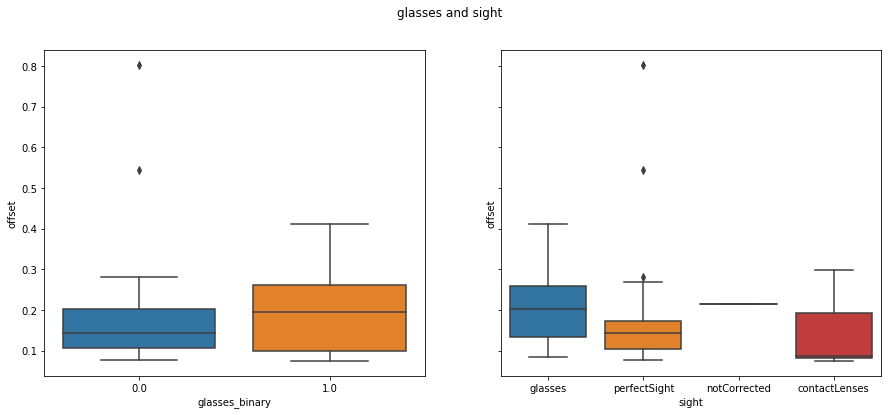

In [50]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('glasses and sight')

sns.boxplot(ax=axes[0], x='glasses_binary', y='offset', data=data_subject)
sns.boxplot(ax=axes[1], x='sight', y='offset', data=data_subject)
   
plt.show()

## Fixation dot positions

In [51]:
if 'glasses_binary' in data_trial_fix.columns: 
    data_trial_fix = data_trial_fix.drop(columns=['glasses_binary'])
data_trial_fix = data_trial_fix.merge(
    data_subject.loc[:, ['run_id', 'glasses_binary', 'sight']],
    on='run_id',
    how='left'
)
grouped_var = data_trial_fix.groupby(['positionIndex', 'glasses_binary']) \
    ['offset', 'precision'].var() \
    .rename(columns={'offset': 'offset_var', 'precision':'precision_var'}) \
    .reset_index()

grouped_means = data_trial_fix.groupby(['positionIndex', 'glasses_binary']) \
    ['offset', 'precision'].mean() \
    .reset_index()

grouped = grouped_means.merge(grouped_var, on=['positionIndex', 'glasses_binary'], how='left')

grouped_offset = grouped.loc[:, ['positionIndex', 'glasses_binary', 'offset']] \
    .set_index(['positionIndex']) \
    .pivot(columns="glasses_binary")['offset'] \
    .reset_index() \
    .rename(columns={0.0: 'offset_glasses_0', 1.0: 'offset_glasses_1'}) 

grouped_offset_var = grouped.loc[:, ['positionIndex', 'glasses_binary', 'offset_var']] \
    .set_index(['positionIndex']) \
    .pivot(columns="glasses_binary")['offset_var'] \
    .reset_index() \
    .rename(columns={0.0: 'offset_var_glasses_0', 1.0: 'offset_var_glasses_1'}) 

grouped_precision = grouped.loc[:, ['positionIndex', 'glasses_binary', 'precision']] \
    .set_index(['positionIndex']) \
    .pivot(columns="glasses_binary")['precision'] \
    .reset_index() \
    .rename(columns={0.0: 'precision_glasses_0', 1.0: 'precision_glasses_1'}) 

grouped_precision_var = grouped.loc[:, ['positionIndex', 'glasses_binary', 'precision_var']] \
    .set_index(['positionIndex']) \
    .pivot(columns="glasses_binary")['precision_var'] \
    .reset_index() \
    .rename(columns={0.0: 'precision_var_glasses_0', 1.0: 'precision_var_glasses_1'}) 

overview = pd.concat(
    [
        grouped_offset,
        grouped_offset_var.iloc[:, 1:3],
        grouped_precision.iloc[:, 1:3], 
        grouped_precision_var.iloc[:, 1:3]
    ], 
    axis=1
)

print(overview.mean(numeric_only=True))
overview

glasses_binary
positionIndex              4.000000
offset_glasses_0           0.183966
offset_glasses_1           0.198186
offset_var_glasses_0       0.032892
offset_var_glasses_1       0.020051
precision_glasses_0        0.079071
precision_glasses_1        0.088290
precision_var_glasses_0    0.003518
precision_var_glasses_1    0.004123
dtype: float64


<ipython-input-51-bb4a7df3b160>:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_var = data_trial_fix.groupby(['positionIndex', 'glasses_binary']) \
<ipython-input-51-bb4a7df3b160>:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_means = data_trial_fix.groupby(['positionIndex', 'glasses_binary']) \


glasses_binary,positionIndex,offset_glasses_0,offset_glasses_1,offset_var_glasses_0,offset_var_glasses_1,precision_glasses_0,precision_glasses_1,precision_var_glasses_0,precision_var_glasses_1
0,0,0.192152,0.199229,0.016382,0.016690,0.093446,0.092738,0.007515,0.002089
1,1,0.169665,0.195415,0.017767,0.011429,0.080472,0.094435,0.003845,0.003504
2,2,0.198891,0.226629,0.041500,0.027907,0.083589,0.105335,0.001612,0.002784
3,3,0.181705,0.166654,0.021911,0.011864,0.083454,0.075801,0.003824,0.002025
4,4,0.152106,0.130017,0.021266,0.007421,0.071141,0.076488,0.002689,0.002608
5,5,0.173571,0.184230,0.039749,0.018476,0.078773,0.080940,0.002803,0.002073
6,6,0.228317,0.233551,0.036951,0.030493,0.080708,0.094219,0.003265,0.008025
7,7,0.166586,0.196800,0.040806,0.026256,0.069153,0.080482,0.002479,0.006967
8,8,0.192702,0.251145,0.059695,0.029923,0.070907,0.094174,0.003635,0.007032


# Gaze predictions

## For each position

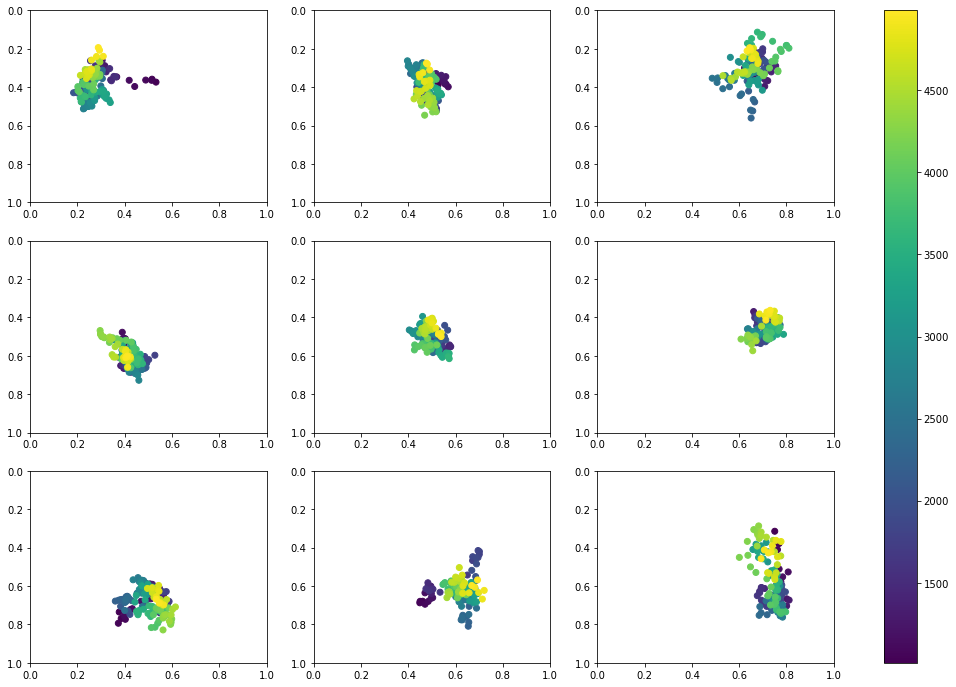

In [52]:
data_plot = add_var_to_data_et(data_et_fix, data_trial, 'chin')
data_plot = data_plot.loc[
    (data_plot['run_id']==43) & 
    (data_plot['chin']==0), :]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
axes = axes.ravel()
xPos = [0.2, 0.5, 0.8, 0.2, 0.5, 0.8, 0.2, 0.5, 0.8]
yPos = [0.2, 0.2, 0.2, 0.5, 0.5, 0.5, 0.8, 0.8, 0.8]
for i in range(0, 9):
    axes_data = data_plot.loc[(data_plot['x_pos']==xPos[i]) & (data_plot['y_pos']==yPos[i]), :]
    im = axes[i].scatter(
        axes_data['x'], 
        axes_data['y'], 
        c=axes_data['t_task'], 
        cmap='viridis'
    )
    axes[i].set_ylim(1, 0)
    axes[i].set_xlim(0, 1)
    
fig.colorbar(im, ax=axes)
plt.show()

## Heatmap

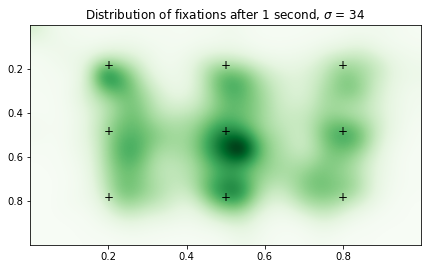

<Figure size 432x288 with 0 Axes>

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter

x = data_et_fix.loc[
    (data_et_fix['x']>0) & (data_et_fix['x']<1) &
    (data_et_fix['y']>0) & (data_et_fix['y']<1),
    'x']

y = data_et_fix.loc[
    (data_et_fix['x']>0) & (data_et_fix['x']<1) &
    (data_et_fix['y']>0) & (data_et_fix['y']<1),
    'y']

def myplot(x, y, s, bins=[1200, 675]):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)
    extent = [xedges[0], xedges[-1], yedges[-1], yedges[0]]
    return heatmap.T, extent

s=34
img, extent = myplot(x, y, s=s)

plt.figure(figsize=(7, 7))
plt.imshow(img, extent=extent, origin='upper', cmap=cm.Greens, aspect=(9/16))
plt.title("Distribution of fixations after 1 second, $\sigma$ = %d" % s)


xPos = [0.2, 0.5, 0.8, 0.2, 0.5, 0.8, 0.2, 0.5, 0.8]
yPos = [0.2, 0.2, 0.2, 0.5, 0.5, 0.5, 0.8, 0.8, 0.8]
for i in range(0, len(xPos)):
    plt.text(xPos[i], yPos[i], '+', size=12, ha="center")

plt.show()
plt.savefig('plots/fix_heatmap.png')

# Calibration: data quality development

In [54]:
data_et_calibration = data_et.loc[data_et['trial_type']=='eyetracking-calibration', :]
data_trial_calibration = data_trial.loc[data_trial['trial_type']=='eyetracking-calibration', :]

## offset

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


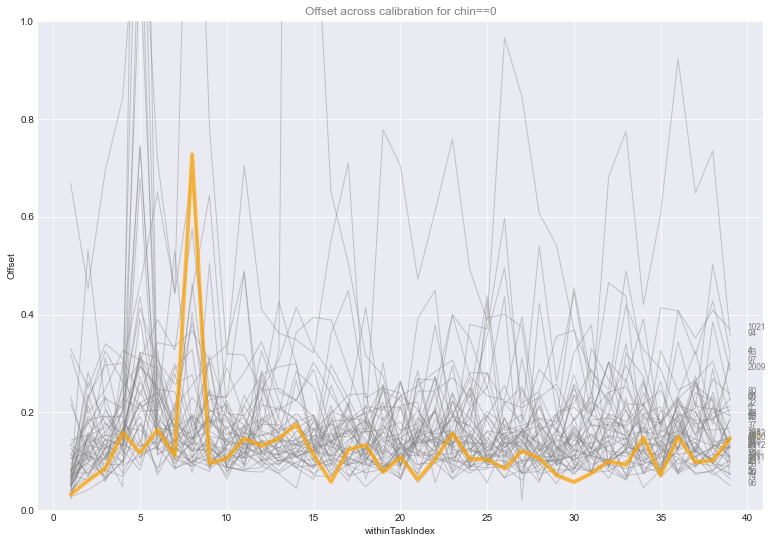

In [55]:
def spaghettiPlot(data, xVar, yVar, highlightedSubject):
    plt.style.use('seaborn-darkgrid')
    fig, ax = plt.subplots(figsize=(13, 9))

    # Draw Plots
    for subject in data["run_id"].unique():
        ax.plot(data.loc[data['run_id']==subject, xVar], 
                data.loc[data['run_id']==subject, yVar], 
                marker='', color='grey', linewidth=1, alpha=0.4)

    # Highlight Subject 
    ax.plot(data.loc[data['run_id']==highlightedSubject, xVar], 
            data.loc[data['run_id']==highlightedSubject, yVar], 
            marker='', color='orange', linewidth=4, alpha=0.7)

    # Let's annotate the plot
    for subject in data["run_id"].unique():
        if subject != highlightedSubject:
            ax.text(data.loc[data['run_id']==subject, xVar].max()+1, 
                    data.loc[data['run_id']==subject, yVar].tail(1),
                    s=subject, horizontalalignment='left', size='small', color='grey')

        else:
            ax.text(data.loc[data['run_id']==subject, xVar].max()+1, 
                    data.loc[data['run_id']==subject, yVar].tail(1),
                    s=subject, horizontalalignment='left', size='small', color='orange')
    return plt

spaghettiPlot(
    data_trial_calibration.loc[data_trial_calibration['chin']==0, :], 
    'withinTaskIndex', 'offset', 103)
plt.ylim(0, 1)
plt.title('Offset across calibration for chin==0', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Offset')

plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


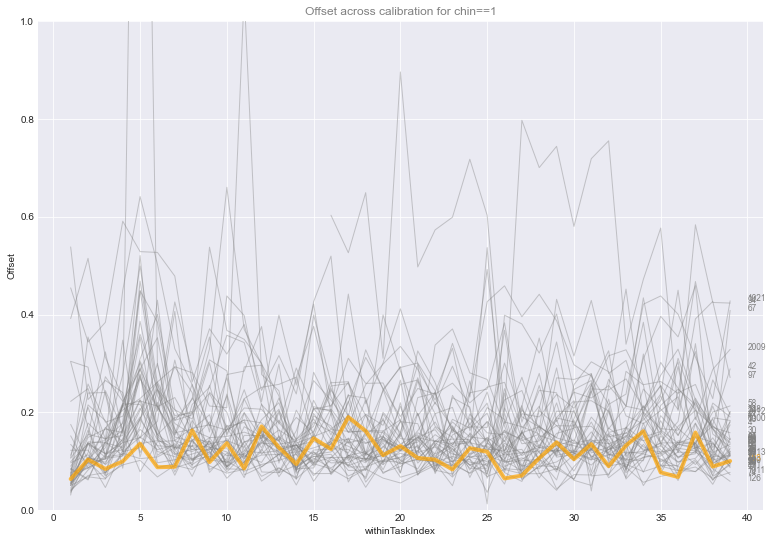

In [56]:
spaghettiPlot(
    data_trial_calibration.loc[data_trial_calibration['chin']==1, :], 
    'withinTaskIndex', 'offset', 103)
plt.ylim(0, 1)
plt.title('Offset across calibration for chin==1', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Offset')

plt.show()

## Precision

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


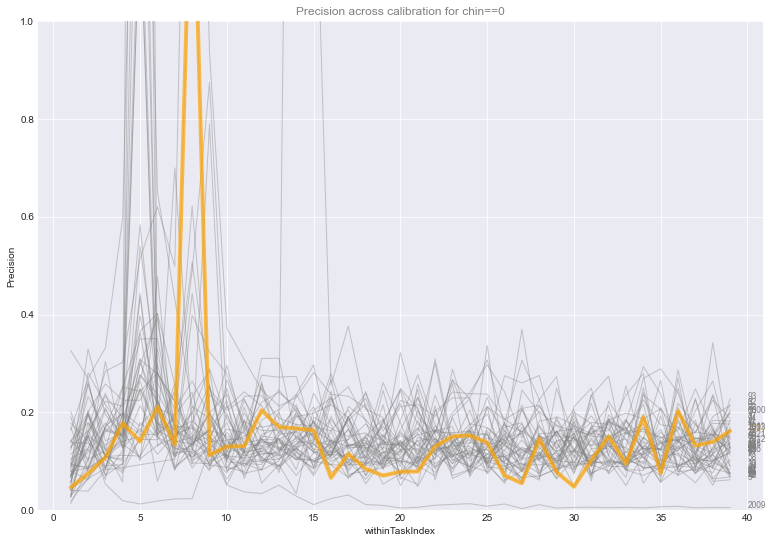

In [57]:
spaghettiPlot(
    data_trial_calibration.loc[data_trial_calibration['chin']==0, :], 
    'withinTaskIndex', 'precision', 103)
plt.ylim(0, 1)
plt.title('Precision across calibration for chin==0', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Precision')

plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


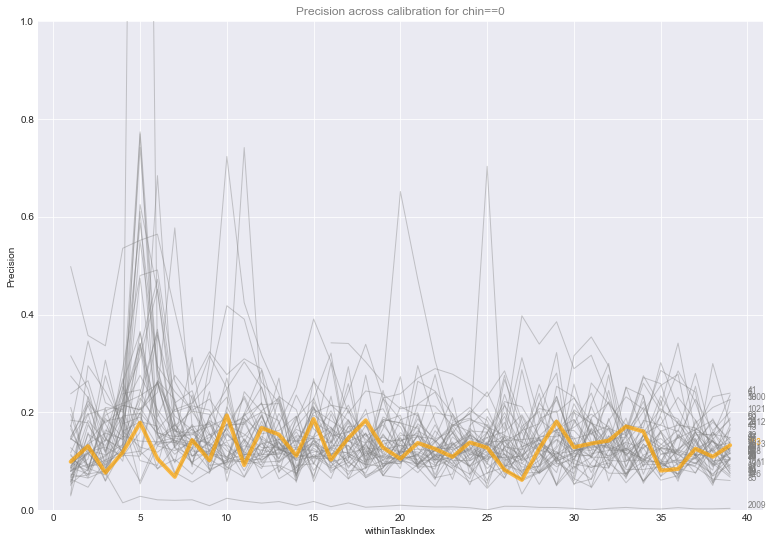

In [58]:
spaghettiPlot(
    data_trial_calibration.loc[data_trial_calibration['chin']==1, :], 
    'withinTaskIndex', 'precision', 103)
plt.ylim(0, 1)
plt.title('Precision across calibration for chin==0', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Precision')

plt.show()

# Categorical confounders

In [69]:
data_subject['browser'].unique()

array(['Chrome', 'Safari', 'Opera', 'Edge', 'Firefox'], dtype=object)

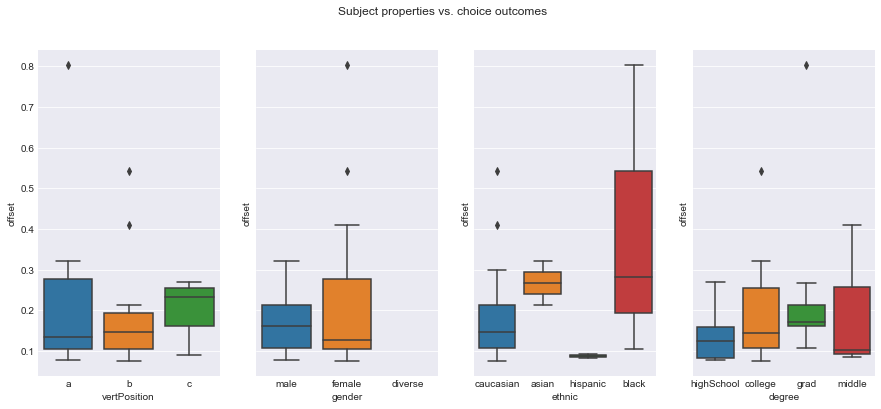

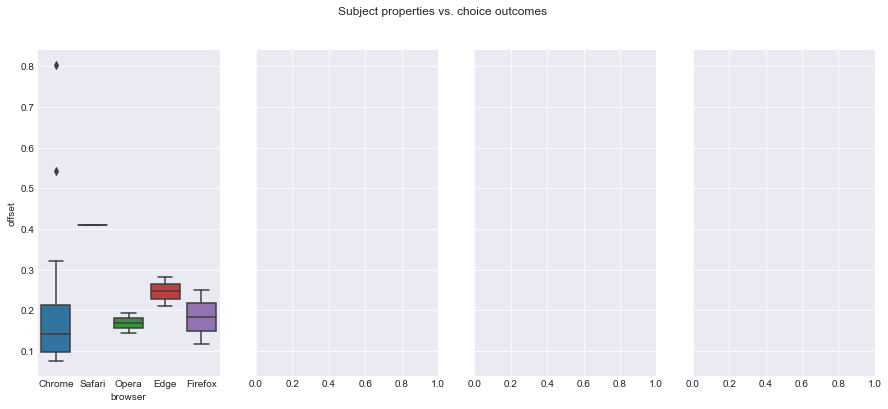

In [71]:
fig, axes = plt.subplots(1, 4, sharey=True, figsize=(3*5, 6))
fig.suptitle('Subject properties vs. choice outcomes')

predictors = ['vertPosition', 'gender', 'ethnic',  'degree' ]  
for i in range(0, len(predictors)):
    sns.boxplot(ax=axes[i], x=predictors[i], y='offset', data=data_subject)

fig, axes = plt.subplots(1, 4, sharey=True, figsize=(3*5, 6))
fig.suptitle('Subject properties vs. choice outcomes')
predictors = ['browser']  
for i in range(0, len(predictors)):
    sns.boxplot(ax=axes[i], x=predictors[i], y='offset', data=data_subject)

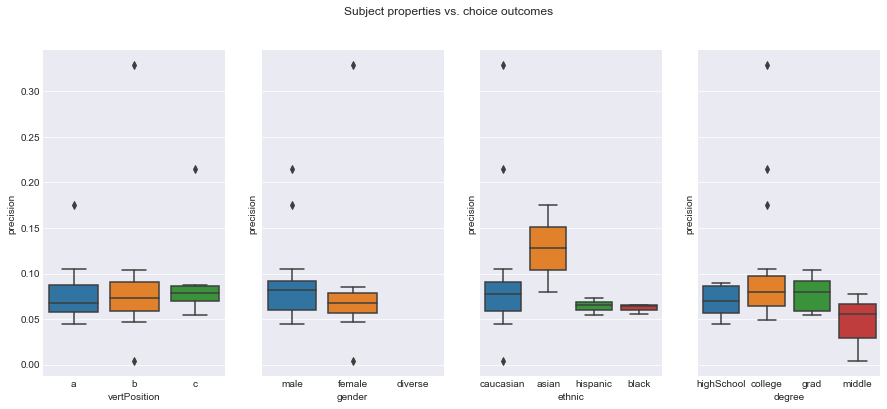

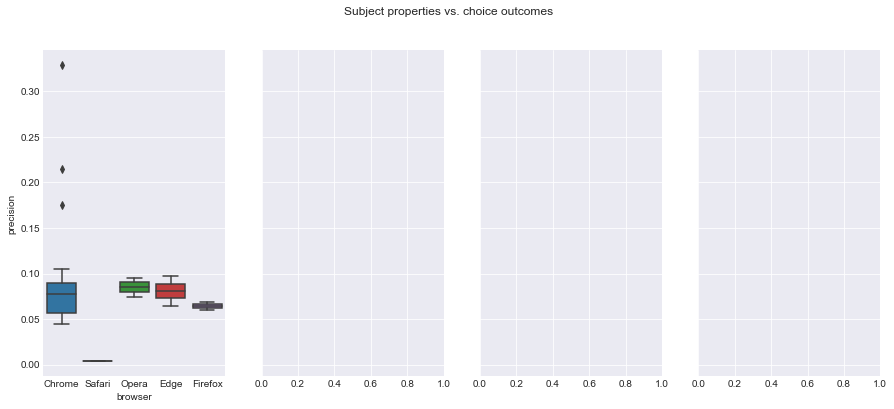

In [72]:
fig, axes = plt.subplots(1, 4, sharey=True, figsize=(3*5, 6))
fig.suptitle('Subject properties vs. choice outcomes')

predictors = [
    'vertPosition',
    'gender',
    'ethnic', 
    'degree'
             ]  
for i in range(0, len(predictors)):
    sns.boxplot(ax=axes[i], x=predictors[i], y='precision', data=data_subject)
    
fig, axes = plt.subplots(1, 4, sharey=True, figsize=(3*5, 6))
fig.suptitle('Subject properties vs. choice outcomes')
predictors = ['browser']  
for i in range(0, len(predictors)):
    sns.boxplot(ax=axes[i], x=predictors[i], y='precision', data=data_subject)

# Correlation Plot

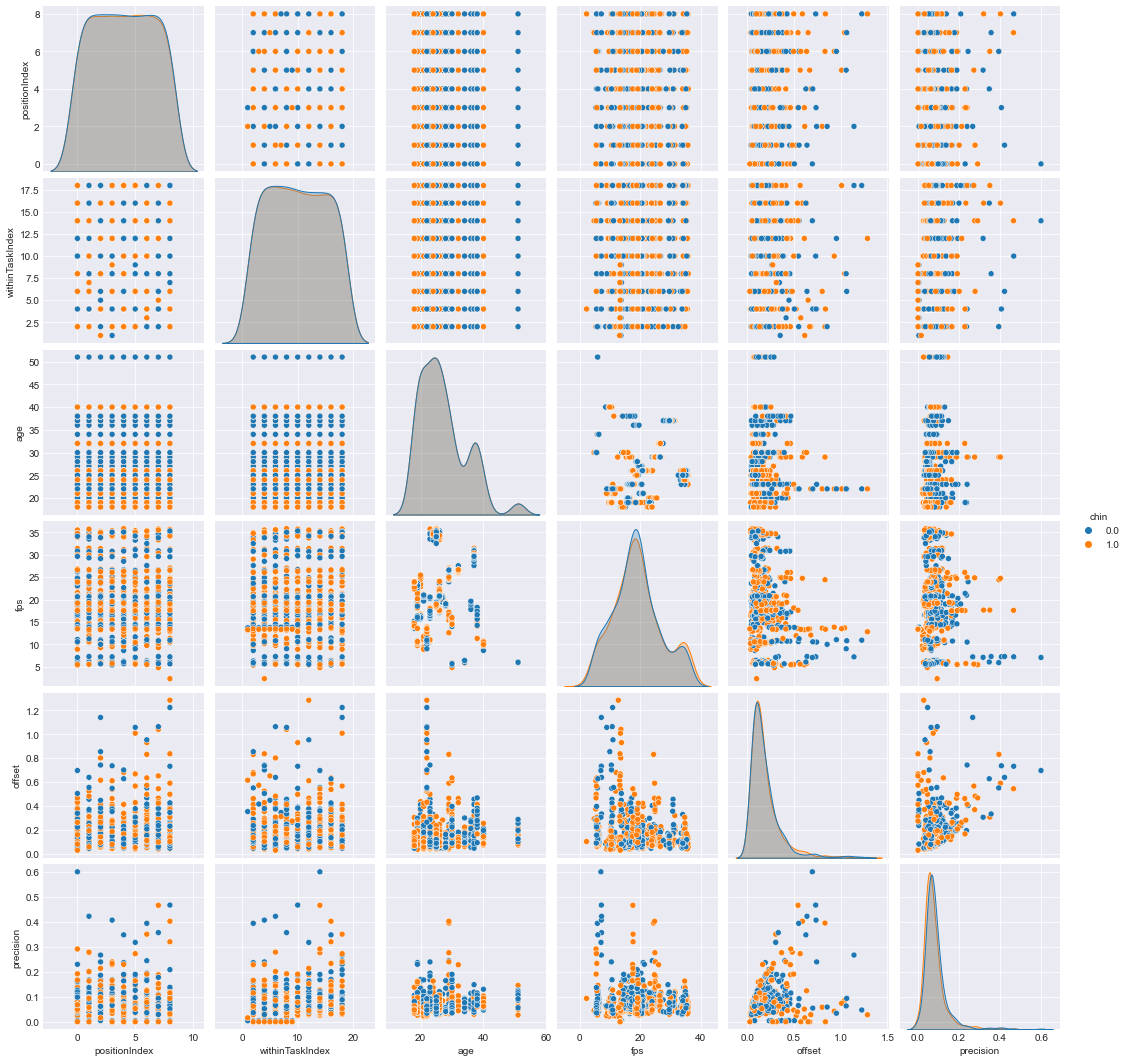

In [61]:
data_plot = data_trial_fix.merge(data_subject.loc[:, ['run_id', 'age']], on='run_id', how='left')
correlation_columns = ['positionIndex', 'withinTaskIndex', 'age', 'fps', 'offset', 'precision']
sns.pairplot(data_plot.loc[:, np.append(correlation_columns, ['chin'])], hue='chin')

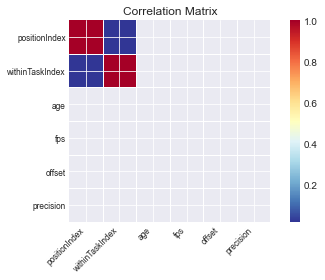

In [62]:
corr_matrix = np.corrcoef(data_plot[correlation_columns].T)
smg.plot_corr(corr_matrix, xnames=correlation_columns)
plt.show()

In [63]:
data_plot[correlation_columns].rcorr()

,positionIndex,withinTaskIndex,age,fps,offset,precision
positionIndex,-,,,,,
withinTaskIndex,0.018,-,,,,
age,-0.004,0.002,-,***,,*
fps,-0.003,0.013,-0.148,-,***,
offset,0.026,-0.002,0.008,-0.249,-,***
precision,-0.071,0.067,0.09,-0.071,0.353,-


In [64]:
data_plot[correlation_columns].rcorr(upper='n')

,positionIndex,withinTaskIndex,age,fps,offset,precision
positionIndex,-,841,754,753,753,753
withinTaskIndex,0.018,-,754,753,753,753
age,-0.004,0.002,-,666,666,666
fps,-0.003,0.013,-0.148,-,753,753
offset,0.026,-0.002,0.008,-0.249,-,753
precision,-0.071,0.067,0.09,-0.071,0.353,-


# MLA Model

In [65]:
data_plot = data_trial_fix.loc[:, ['run_id', 'chin', 'x_pos', 'y_pos', 'precision']]
null_data = data_plot.loc[data_plot.isnull().any(axis=1), :]
data_plot = data_plot.loc[pd.notna(data_plot['precision']), :].reset_index(drop=True)
data_plot.loc[data_plot.isnull().any(axis=1), :]
model = smf.mixedlm("precision ~ x_pos", data_plot, groups=data_plot["run_id"])
model_fit = model.fit()
print(model_fit.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: precision
No. Observations: 753     Method:             REML     
No. Groups:       42      Scale:              0.0014   
Min. group size:  15      Log-Likelihood:     1318.6700
Max. group size:  18      Converged:          Yes      
Mean group size:  17.9                                 
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     0.085    0.008 10.187 0.000  0.069  0.101
x_pos        -0.003    0.006 -0.593 0.553 -0.014  0.008
Group Var     0.003    0.016                           



C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2168: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


# Export

In [66]:
data_et_calibration.to_csv("data_jupyter/data_et_calibration.csv", index=False, header=True)
data_trial_calibration.to_csv("data_jupyter/data_trial_calibration.csv", index=False, header=True)

data_et_fix.to_csv("data_jupyter/data_et_fix.csv", index=False, header=True)
data_trial_fix.to_csv("data_jupyter/data_trial_fix.csv", index=False, header=True)

data_subject.to_csv("data_jupyter/data_subject.csv", index=False, header=True)

# Feedback

In [67]:
print('Success! Script ran through')

Success! Script ran through
